In [6]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

In [7]:
path_to_file = os.path.join('..', 'data', 'processed_data.csv')

df = pd.read_csv(path_to_file)
df.head()

,SITE_ID,LOCATION,DATE_TIME,NO,NOX,NO2,PM2_5,PM10,Latitude,Longitude
0,188,AURN Bristol Centre,1993-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
1,188,AURN Bristol Centre,1993-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
2,188,AURN Bristol Centre,1993-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
3,188,AURN Bristol Centre,1993-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
4,188,AURN Bristol Centre,1993-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649


In [8]:
df = df[['SITE_ID', 'DATE_TIME', 'NOX']]

sites_inside_caz = [500, 501, 672]
sites_outside_caz = [203, 215, 270, 452, 463]

start_date = '2021-11-28 07:00:00'
end_date = '2023-11-28 18:00:00'

filter = (df['SITE_ID'].isin(sites_inside_caz + sites_outside_caz) ) & (df['DATE_TIME'].between(start_date, end_date))
df = df[filter]

df.head()

,SITE_ID,DATE_TIME,NOX
289490,203,2021-12-01 00:00:00,4.00
289491,203,2021-12-01 01:00:00,2.00
289492,203,2021-12-01 02:00:00,1.25
289493,203,2021-12-01 03:00:00,1.00
289494,203,2021-12-01 04:00:00,1.50


In [9]:

df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

df['NOX'] = pd.to_numeric(df['NOX'], errors='coerce')

unique_sites = df['SITE_ID'].unique()
daily_dfs = []

for site in unique_sites:
    site_df = df[df['SITE_ID'] == site].copy()
    site_df.set_index('DATE_TIME', inplace=True)
    
    daily_site_df = site_df[['NOX']].resample('D').mean()
    daily_site_df['NOX'] = daily_site_df['NOX'].ffill()
    
    daily_site_df['SITE_ID'] = site
    daily_site_df.reset_index(inplace=True)
    
    daily_dfs.append(daily_site_df)

full_daily_df = pd.concat(daily_dfs, ignore_index=True)
full_daily_df.dropna(inplace=True)


treated_site_ids = sites_inside_caz

full_daily_df['is_treated'] = full_daily_df['SITE_ID'].isin(treated_site_ids).astype(int)

caz_launch_date = pd.to_datetime('2022-11-28')

full_daily_df['is_post'] = (full_daily_df['DATE_TIME'] >= caz_launch_date).astype(int)

full_daily_df['is_post_treated'] = full_daily_df['is_post'] * full_daily_df['is_treated']

X = full_daily_df[['is_treated', 'is_post', 'is_post_treated']]
y = full_daily_df['NOX']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print("\n Difference-in-Differences Analysis Summary:")
print(model.summary())


 Difference-in-Differences Analysis Summary:
                            OLS Regression Results                            
Dep. Variable:                    NOX   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     281.7
Date:                Thu, 04 Sep 2025   Prob (F-statistic):          8.88e-171
Time:                        09:51:02   Log-Likelihood:                -31401.
No. Observations:                5848   AIC:                         6.281e+04
Df Residuals:                    5844   BIC:                         6.284e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

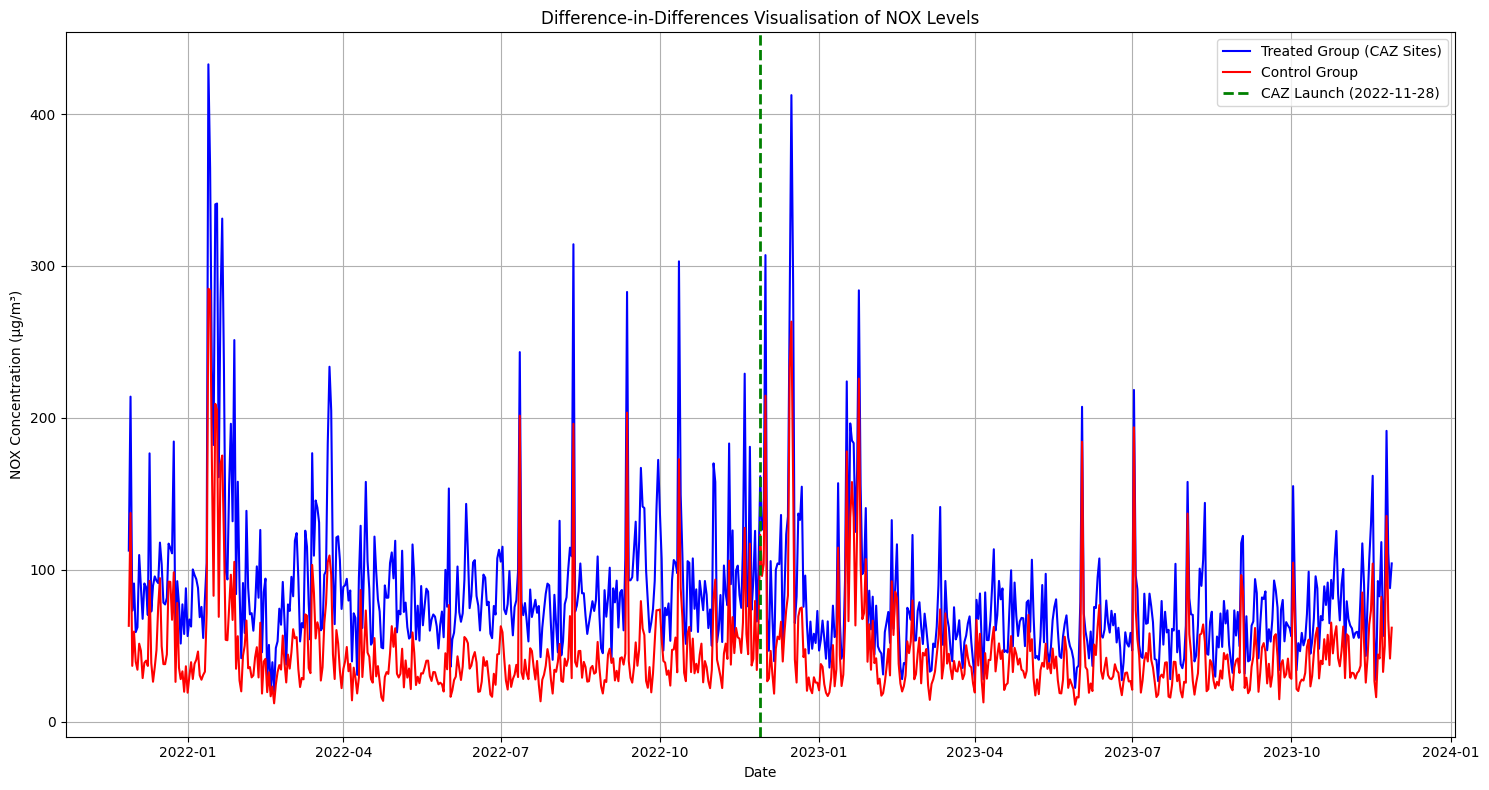

In [10]:

full_daily_df['group'] = full_daily_df['SITE_ID'].apply(lambda x: 'Treated' if x in treated_site_ids else 'Control')

group_averages = full_daily_df.groupby(['DATE_TIME', 'group'])['NOX'].mean().unstack()

caz_launch_date = pd.to_datetime('2022-11-28')

plt.figure(figsize=(15, 8))

plt.plot(group_averages.index, group_averages['Treated'], label='Treated Group (CAZ Sites)', color='blue')
plt.plot(group_averages.index, group_averages['Control'], label='Control Group', color='red')

plt.axvline(caz_launch_date, color='green', linestyle='--', linewidth=2, label='CAZ Launch (2022-11-28)')

plt.title('Difference-in-Differences Visualisation of NOX Levels')
plt.xlabel('Date')
plt.ylabel('NOX Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join('..', 'img', 'DiD_NOX_Levels.png'))
plt.show()